In [3]:
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

# Part 1: TF Hub

## Load Classifier

In [15]:
CLASSIFIER_URL ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2"
IMAGE_RES = 224

model = tf.keras.Sequential([
    hub.KerasLayer(CLASSIFIER_URL, input_shape=(IMAGE_RES, IMAGE_RES, 3))
])

## Load image from the internet

57344/50652 [=================================] - 0s 2us/step


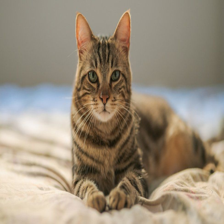

In [23]:
import numpy as np
import PIL.Image as Image

img = tf.keras.utils.get_file('cat.jpg','https://ichef.bbci.co.uk/news/976/cpsprodpb/12A9B/production/_111434467_gettyimages-1143489763.jpg')
img = Image.open(img).resize((IMAGE_RES, IMAGE_RES))
img 

In [24]:
img = np.array(img)/255.0
img.shape

(224, 224, 3)

## Predict image class

In [25]:
result = model.predict(img[np.newaxis, ...])
result.shape

(1, 1001)

In [42]:
print (img.shape)
print (img[np.newaxis, ...].shape)
print (np.array([img]).shape)

(224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


In [43]:
predicted_class = np.argmax(result[0], axis=-1)
predicted_class

283

## Get classes names and assign predicted class

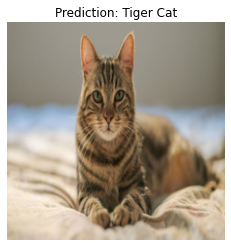

In [44]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

plt.imshow(img)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())

# Part 2: TF Hub for Cats VS Dogs

## Load data

In [45]:
(train_examples, validation_examples), info = tfds.load(
    'cats_vs_dogs', 
    with_info=True, 
    as_supervised=True, 
    split=['train[:80%]', 'train[80%:]'],
)

num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes

.27 MiB/s]
Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]
Generating train examples...: 0 examples [00:00, ? examples/s]
Generating train examples...: 1 examples [00:00,  6.63 examples/s]
Generating train examples...: 121 examples [00:00, 585.37 examples/s]
Generating train examples...: 249 examples [00:00, 867.07 examples/s]
Generating train examples...: 376 examples [00:00, 1012.72 examples/s]
Generating train examples...: 508 examples [00:00, 1116.98 examples/s]
Generating train examples...: 638 examples [00:00, 1175.85 examples/s]
Generating train examples...: 762 examples [00:00, 1195.94 examples/s]
Generating train examples...: 884 examples [00:00, 1172.67 examples/s]
Generating train examples...: 1003 examples [00:00, 1164.89 examples/s]
Generating train examples...: 1121 examples [00:01, 1149.58 examples/s]
Generating train examples...: 1239 examples [00:01, 1155.62 examples/s]
Generating train examples...: 1356 examples [00:01, 1140.10 examples/s]
Generating 

In [57]:
for i, example_image in enumerate(train_examples.take(3)):
  print("Image {} shape: {}".format(i+1, example_image[0].shape))

Image 1 shape: (262, 350, 3)
Image 2 shape: (409, 336, 3)
Image 3 shape: (493, 500, 3)


In [58]:
def format_image(image, label):
  image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
  return image, label

BATCH_SIZE = 32

train_batches = train_examples.shuffle(num_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)

validation_batches = validation_examples.map(format_image).batch(BATCH_SIZE).prefetch(1)

In [59]:
image_batch, label_batch = next(iter(train_batches.take(1)))
image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

result_batch = model.predict(image_batch)

predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
predicted_class_names

array(['German shepherd', 'schipperke', 'tabby', 'Egyptian cat',
       'Rottweiler', 'tabby', 'kelpie', 'tiger cat', 'miniature pinscher',
       'Labrador retriever', 'Egyptian cat', 'Maltese dog', 'tabby',
       'Border collie', 'Persian cat', 'dishwasher', 'tabby',
       'Staffordshire bullterrier', 'tabby', 'beagle', 'Siamese cat',
       'Staffordshire bullterrier', 'Egyptian cat', 'Tibetan mastiff',
       'German shepherd', 'tiger cat', 'tabby',
       'German short-haired pointer', 'Egyptian cat', 'toy terrier',
       'tabby', 'giant schnauzer'], dtype='<U30')

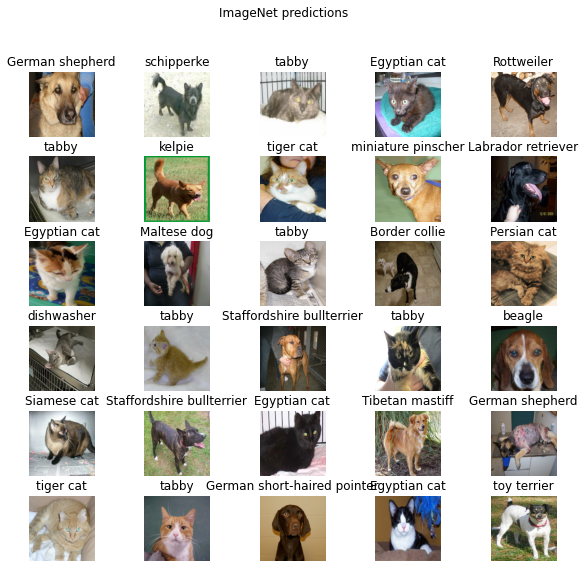

In [60]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

## Get the model

In [61]:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2"
feature_extractor = hub.KerasLayer(URL,
                                   input_shape=(IMAGE_RES, IMAGE_RES,3))

In [62]:
feature_batch = feature_extractor(image_batch)
print(feature_batch.shape)

(32, 1280)


In [63]:
feature_extractor.trainable = False

In [65]:
model = tf.keras.Sequential([
  feature_extractor,
  tf.keras.layers.Dense(2)
])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_3 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


## Train the model

In [66]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

EPOCHS = 2
history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/6
582/582 [==============================] - 26s 37ms/step - loss: 0.0573 - accuracy: 0.9810 - val_loss: 0.0360 - val_accuracy: 0.9882
Epoch 2/6
582/582 [==============================] - 20s 33ms/step - loss: 0.0314 - accuracy: 0.9886 - val_loss: 0.0319 - val_accuracy: 0.9888
Epoch 3/6
582/582 [==============================] - 22s 36ms/step - loss: 0.0260 - accuracy: 0.9905 - val_loss: 0.0369 - val_accuracy: 0.9880
Epoch 4/6
582/582 [==============================] - 22s 36ms/step - loss: 0.0221 - accuracy: 0.9923 - val_loss: 0.0324 - val_accuracy: 0.9899
Epoch 5/6
582/582 [==============================] - 22s 36ms/step - loss: 0.0193 - accuracy: 0.9933 - val_loss: 0.0337 - val_accuracy: 0.9897
Epoch 6/6
582/582 [==============================] - 23s 37ms/step - loss: 0.0180 - accuracy: 0.9937 - val_loss: 0.0334 - val_accuracy: 0.9895


## Visualize training history

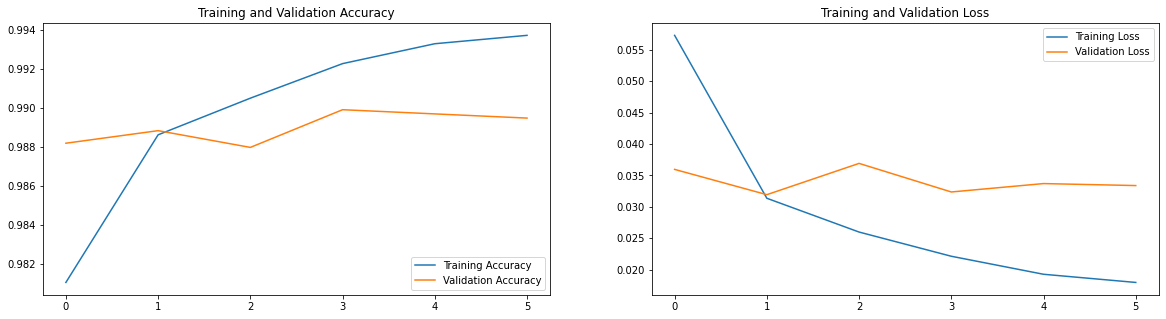

In [72]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [68]:
class_names = np.array(info.features['label'].names)
class_names

array(['cat', 'dog'], dtype='<U3')

In [69]:
predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()
predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]
predicted_class_names

array(['dog', 'dog', 'cat', 'cat', 'dog', 'cat', 'dog', 'cat', 'dog',
       'dog', 'cat', 'dog', 'cat', 'dog', 'cat', 'cat', 'cat', 'dog',
       'cat', 'dog', 'cat', 'dog', 'cat', 'dog', 'dog', 'cat', 'cat',
       'dog', 'cat', 'dog', 'cat', 'dog'], dtype='<U3')

In [70]:
print("Labels: ", label_batch)
print("Predicted labels: ", predicted_ids)

Labels:  [1 1 0 0 1 0 1 0 1 1 0 1 0 1 0 0 0 1 0 1 0 1 0 1 1 0 0 1 0 1 0 1]
Predicted labels:  [1 1 0 0 1 0 1 0 1 1 0 1 0 1 0 0 0 1 0 1 0 1 0 1 1 0 0 1 0 1 0 1]


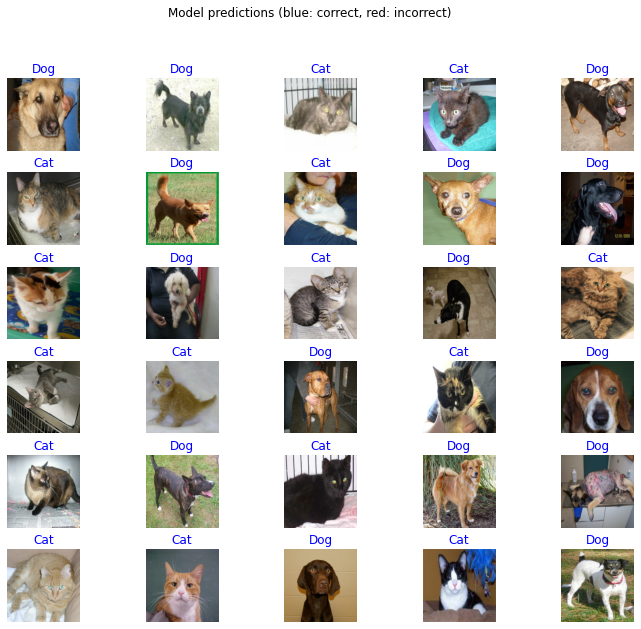

In [75]:
plt.figure(figsize=(12,10))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  color = "blue" if predicted_ids[n] == label_batch[n] else "red"
  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")